# SDGP SE-12 NerveSeg-US Data Model

## Pre-Processing of Images for the ML Model

For our SDGP project we will use this procedure for the pre-processing of data. Since the dataset is unlabelled and using unsupervised learning approach

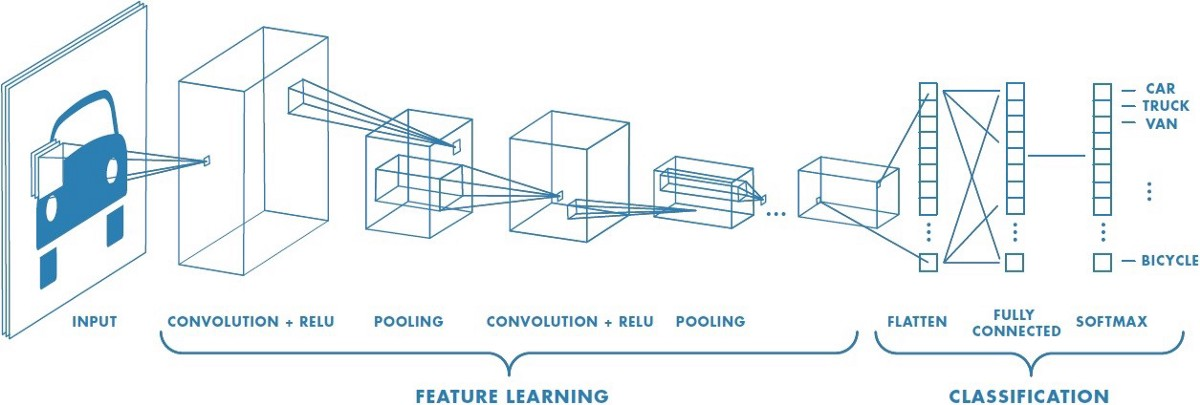

In [10]:
#Importing OS Module
import os

#Importing re pattern in RegEx
import re

#Importing numpy
import numpy as np

#Importing Pandas
import pandas as pd

#importing pyplot interface
import matplotlib.pyplot as plt
import re
#importing openCV for computer vision
import cv2
#Importing other dependencies in order to pre process
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold
#Importing tensorflow I/O
import tensorflow_io as tfio

#Importing Keras
import keras

#Importing tensorflow
import tensorflow as tf
#Importing keras dependencies

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
plt.style.use("ggplot")
%matplotlib inline
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.layers.core import Lambda, RepeatVector, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from PIL import Image,ImageFilter
K.set_image_data_format('channels_last')

In [2]:
file_path=pd.DataFrame({'image_path':os.listdir('D:\\2nd Year Tutorials\\SDGP Project\\Project\\Project-NerveSeg-US\\Back-End\\train')})
file_path_test=pd.DataFrame({'image_path':os.listdir('D:\\2nd Year Tutorials\\SDGP Project\\Project\\Project-NerveSeg-US\\Back-End\\test')})

In [3]:
subject=file_path.image_path.apply(lambda x:re.split('_',x)[0])
img_name=file_path_test.image_path.apply(lambda x:x.split('.')[0])
grb=file_path.image_path.apply(lambda x:re.search('_[0-9]+',x).group())
image_name=grb.apply(lambda x:re.split('_',x)[1])

In [4]:
file_path['image_name']=image_name
file_path['subject_name']=subject
file_path_test['image_name']=img_name

In [5]:
file_path.image_path=file_path.image_path.apply(lambda x:'train/'+x)
file_path_test.image_path=file_path_test.image_path.apply(lambda x:'test/'+x)

In [6]:
msk=[i for i in range(len(file_path.image_path)) if 'mask' in file_path.image_path[i]]
img=[i for i in range(len(file_path.image_path)) if 'mask' not in file_path.image_path[i]]
msk=file_path.loc[msk]
img=file_path.loc[img]

In [7]:
msk=msk.sort_values(by=['image_name','subject_name'])
img=img.sort_values(by=['image_name','subject_name'])

In [8]:
img['mask_path']=msk.image_path.values

In [9]:
print('Number of unique subjects',len(img.subject_name.value_counts()))
print('Number of images per subject',len(img.image_name.value_counts()))

Number of unique subjects 47
Number of images per subject 120


In [11]:
img.head()

image_path image_name subject_name            mask_path
2398   train/1_1.tif          1            1   train/1_1_mask.tif
0     train/10_1.tif          1           10  train/10_1_mask.tif
240   train/11_1.tif          1           11  train/11_1_mask.tif
480   train/12_1.tif          1           12  train/12_1_mask.tif
720   train/13_1.tif          1           13  train/13_1_mask.tif

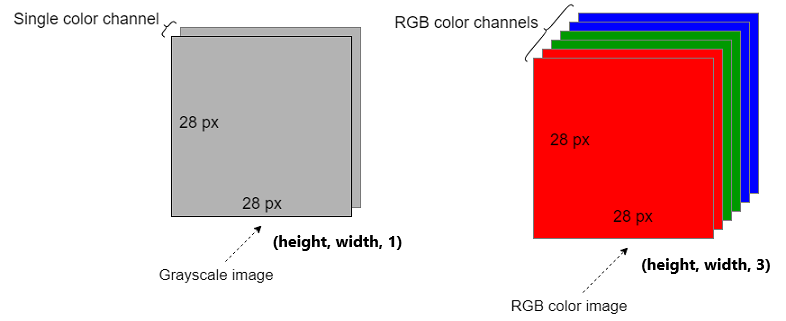

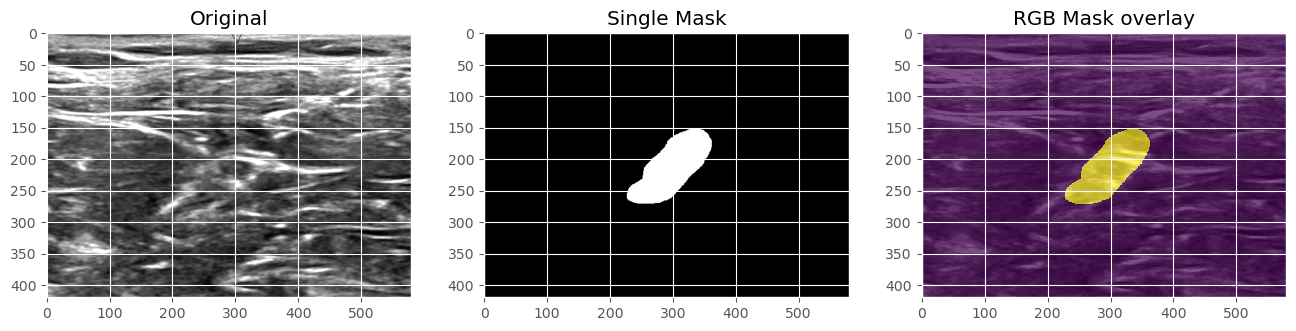

In [19]:
img_arr=np.array(Image.open(img.iloc[5].image_path))
image1_mask = np.array(Image.open(img.iloc[5].mask_path))
fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(img_arr, cmap = 'gray')
ax[0].set_title('Original')

ax[1].imshow(image1_mask, cmap = 'gray')
ax[1].set_title('Single Mask')
ax[2].imshow(img_arr, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, interpolation = 'none', alpha = 0.7)
ax[2].set_title('RGB Mask overlay')
plt.show()


In [13]:
X1 = np.zeros((len(img), 12, 12), dtype=np.float32)
for i in range(len(img)):
  img1=cv2.imread(img.image_path.iloc[i],cv2.IMREAD_GRAYSCALE)
  img1=resize(img1, (12, 12), mode = 'constant', preserve_range = True)
  X1[i]=img1

In [14]:
from tqdm import tqdm
sim=dict()
for i in tqdm(range(len(X1))):
  for j in range(len(X1)):
      if i!=j:
        if tuple(sorted((i,j))) not in sim.keys():
          simil=ssim(X1[i],X1[j])
          if abs(simil)>0.95:
            sim[tuple(sorted((i,j)))]=simil

100%|████████████████████████████████████████████████████████████████████████████| 5635/5635 [1:39:55<00:00,  1.06s/it]


In [15]:
from tqdm import tqdm

In [16]:
conf=[]
for i in tqdm(sim.keys()):
  if sim[i]>0.999:
    msk1=cv2.imread(img.mask_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
    msk2=cv2.imread(img.mask_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
    if msk1.any()!=msk2.any():
      conf.append(i)

100%|██████████████████████████████████████████████████████████████████████████| 18826/18826 [00:06<00:00, 2816.49it/s]


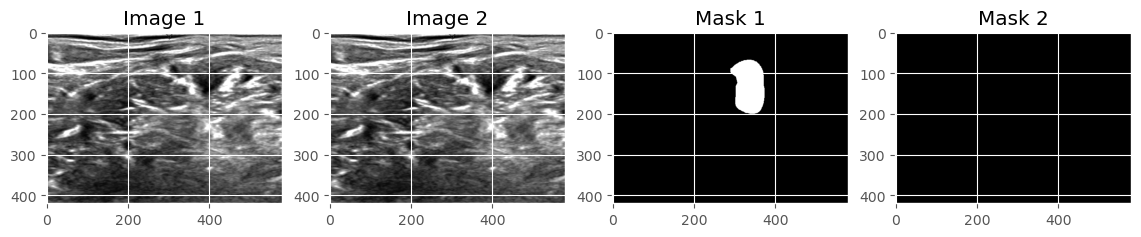

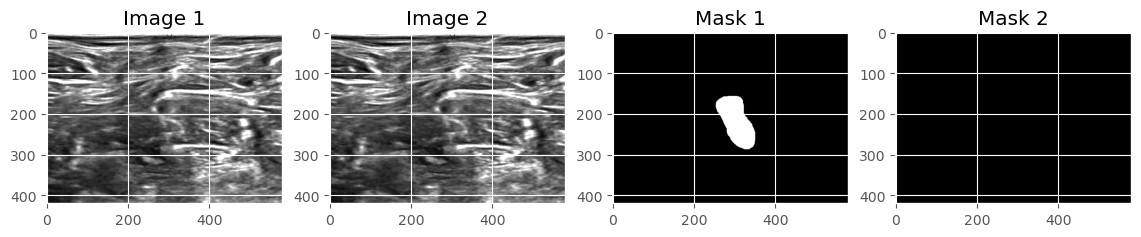

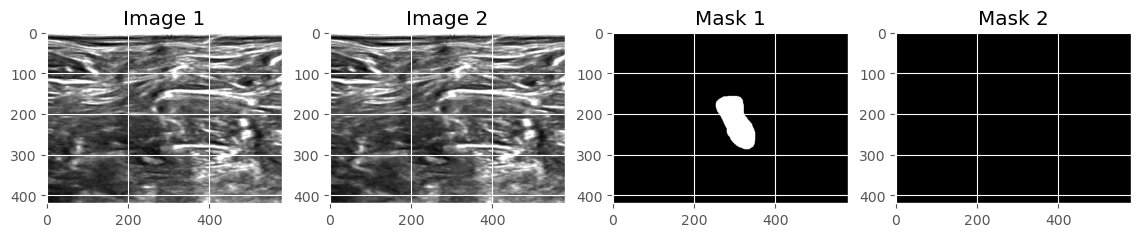

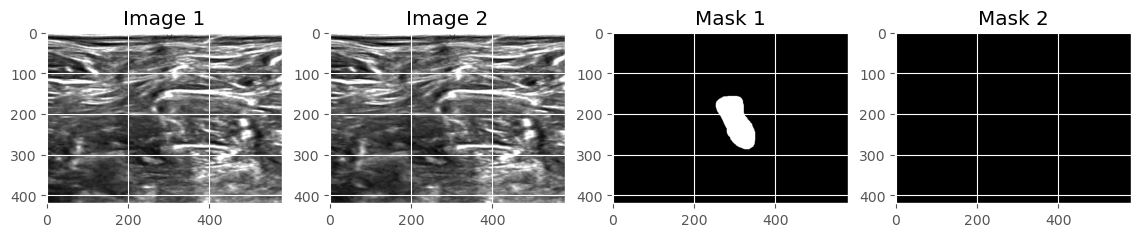

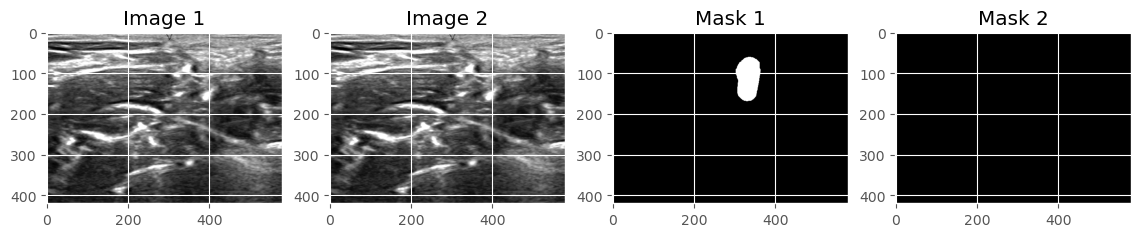

In [17]:
cnt=0
for i in conf:
  fig,ax=plt.subplots(1,4,figsize=(14,7))
  cnt+=1
  img1=cv2.imread(img.image_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
  ax[0].imshow(img1,cmap='gray')
  ax[0].set_title('Image 1')
  img2=cv2.imread(img.image_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
  ax[1].imshow(img2,cmap='gray')
  ax[1].set_title('Image 2')
  msk1=cv2.imread(img.mask_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
  ax[2].imshow(msk1,cmap='gray')
  ax[2].set_title('Mask 1')
  msk2=cv2.imread(img.mask_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
  ax[3].imshow(msk2,cmap='gray')
  ax[3].set_title('Mask 2')
  if cnt==5:
    break